# Modelli Non Parametrici: Stima di Densità, Nearest Neighbor, Metodi basati su Kernel
## Apprendimento Automatico | LM in Data Science
##                 

da Python Machine Learning - Code Examples e [doc sklearn](https://scikit-learn.org/stable/user_guide.html#)

In [1]:
from IPython.display import Image
%matplotlib inline

# K-Nearest Neighbors

## Caricamento Dataset

Caricamento del dataset **Iris** di scikit-learn

- terza colonna: lunghezza petalo
- quarta colonna: ampiezza petalo
- classi già convertite in interi: 
    * `0` = *Iris-Setosa*, `1` = *Iris-Versicolor*, `2` = *Iris-Virginica*

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


**Suddivisione** dei dati in `70%` per il *training* e `30%` per il *test*:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


**Standardizzazione** delle feature:

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup dei marker e della mappa colori
    markers = ('s', '^', 'o', '*', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot della superficie di decisione
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                    c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

    # evidenzia es. di test
    if test_idx:
        # plot di tutti gli es.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],  
                    c='white', edgecolor='black', alpha=0.5, 
                    linewidth=1, marker='o', s=100, label='test')

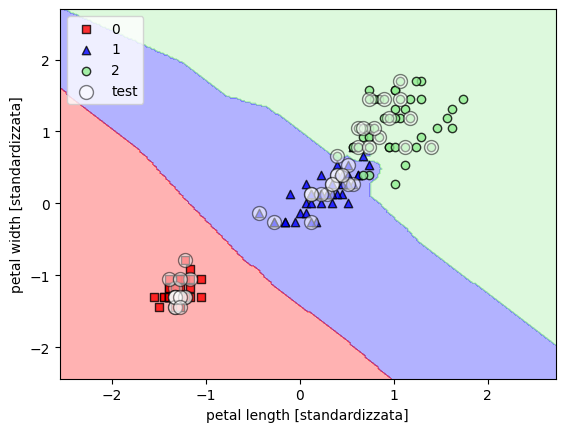

In [7]:
from sklearn.neighbors import KNeighborsClassifier

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardizzata]')
plt.ylabel('petal width [standardizzata]')
plt.legend(loc='upper left')
#plt.tight_layout()
plt.show()

Alternativa [`RadiusNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier): implementa la scelta dei vicini entro un raggio $r$ prefissato da ogni esempio di training, con $r \in \mathbb{R}$ specificato dall'utente

- metodo più efficace quando i dati _non sono campionati uniformemente_
- dato il raggio $r$ specificato dall'utente, per classificare esempi in vicinati _più sparsi_ si userà un numero minore di vicini più prossimi
- risulta _meno efficace_ per spazi di parametri con un gran numero di dimensioni (“curse of dimensionality”)

__Esempio__ `RadiusNeighborsClassifier` con Iris

`weights{‘uniform’, ‘distance’}` pesatura dei vicini: uniforme | basata sula distanza dall'es. da classificare

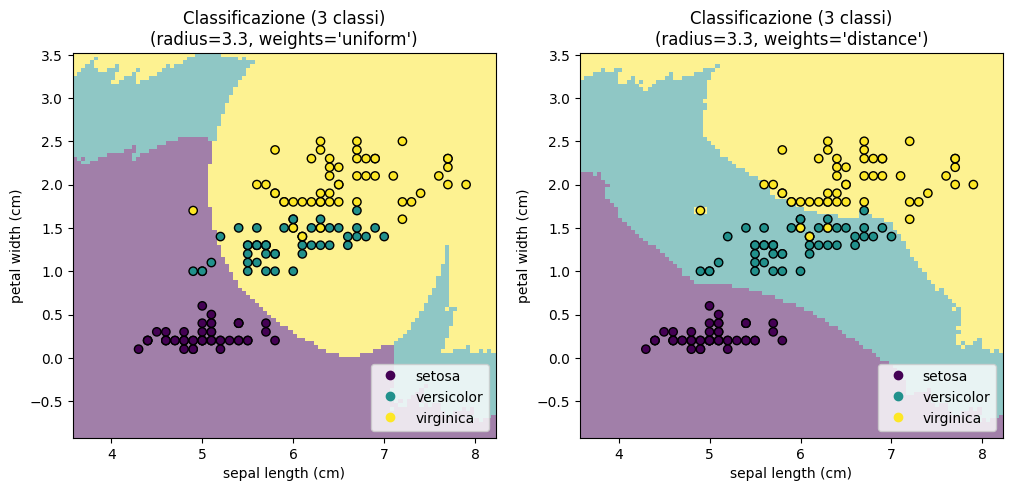

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "petal width (cm)"]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = Pipeline(steps=[("scaler", StandardScaler()), ("rnn", RadiusNeighborsClassifier(radius=3.3, algorithm='ball_tree'))])

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(rnn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[3],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="lower right",
    )
    _ = disp.ax_.set_title(
        f"Classificazione (3 classi)\n(radius={clf[-1].radius}, weights={weights!r})"
    )

plt.show()

### Regressione con Nearest Neighbors

Metodi NN per problemi di regressione:  etichetta assegnata come media delle etichette nel vicinato

- [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) implementa la ricerca dei $k$ vicini più prossimi del punto da etichettare
- [RadiusNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor) simile ma con vicini dentro un'ipersfera di raggio $r$ centrata nel punto da etichettare

__Pesi__ - parametro `weights`
- `uniform`: versione base con pesi uniformi: ogni punto del vicinato conta alla stessa maniera 
- `distance`: pesi proporzionali all'inverso della distanza 
- calcolo tramite funzione di distanza passata dall'utente 

#### Esempio

dalla [doc](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py) di sklearn

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png)

### Esempio 

Task: completamento di volti

- [adattato](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multioutput_face_completion.html#sphx-glr-auto-examples-miscellaneous-plot-multioutput-face-completion-py)

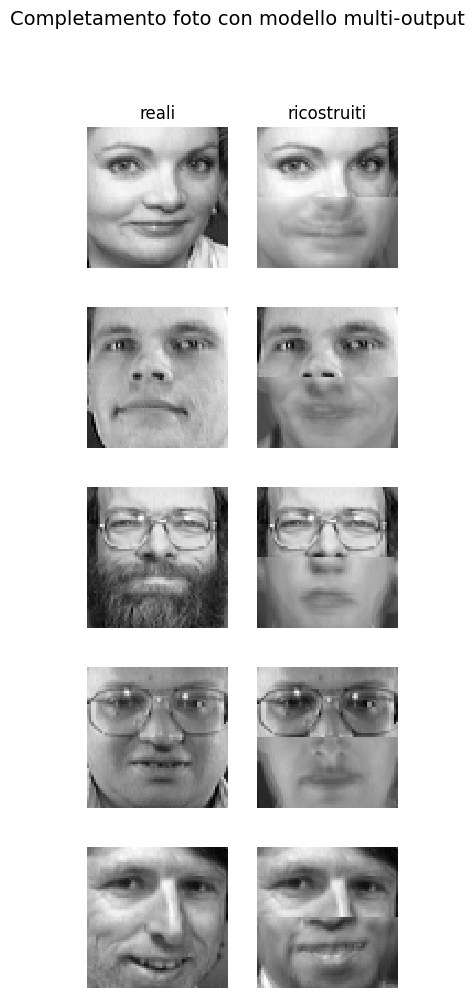

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.validation import check_random_state

# carica i dataset
data, targets = fetch_olivetti_faces(return_X_y=True)

train = data[targets < 30]
test = data[targets >= 30]  # Test su diverso insieme di persone 

# Test su un sottoinsieme 
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

n_pixels = data.shape[1]
# metà superiore dei volti
X_train = train[:, : (n_pixels + 1) // 2]
# metà inferiore dei volti
y_train = train[:, n_pixels // 2 :]
X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

# Addestramento
estimator = KNeighborsRegressor()

estimator.fit(X_train, y_train)
y_test_predict = estimator.predict(X_test)

# mostra volti completati
image_shape = (64, 64)

n_cols = 2
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Completamento foto con modello multi-output", size=14)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="reali")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")

    completed_face = np.hstack((X_test[i], y_test_predict[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 2)

    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 2, title="ricostruiti")

    sub.axis("off")
    sub.imshow(
        completed_face.reshape(image_shape),
        cmap=plt.cm.gray,
        interpolation="nearest",
    )

plt.show()

### Apprendimento Non Supervisionato

`NearestNeighbors` implementa l'apprendimento _non supervisionato_ di strutture dati atte a velocizzare la ricerca dei vicini
- interfaccia uniforme per diversi algoritmi: 
    - `BallTree` 
    - `KDTree` 
    - algoritmo a _forza bruta_ basato sulle metriche in `sklearn.metrics.pairwise`, cfr. [sezione](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric) sulle distanze
- nei classificatori/regressori NN, scelta dell'algoritmo di ricerca dei vicini controllata tramite la keyword `algorithm`: 
    - `auto`, `ball_tree`, `kd_tree`, `brute`
        - con `auto`, l'algoritmo cerca di determinare l'approccio migliore in base ai dati
        - cfr. [sezione](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms) dedicata


In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
nuovo = [0,1]
dist, ind = nbrs.kneighbors([nuovo])

for j in range(3):
    print('vicino',X[j],'a distanza', dist[0,j])

vicino [-1 -1] a distanza 1.0
vicino [-2 -1] a distanza 2.0
vicino [-3 -2] a distanza 2.23606797749979


### Precalcolo dei NN

esempio dalla [doc](https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html)

### Grafi di connettività

`kneighbors_graph` e `radius_neighbors_graph` 

- usati per creare grafi sparsi che mostrano le _connessioni_ fra istanze vicine da utilizzare in algo. non supervisionati per la riduzione della dim. o il clustering

In [11]:
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(X, 3, mode='connectivity', include_self=False).toarray()
print('matrice di adiacenza del grafo:\n',A)

matrice di adiacenza del grafo:
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


## Apprendimento di Distanze

__Neighborhood Components Analysis__ (NCA), [`NeighborhoodComponentsAnalysis`](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) metodo di apprendimento di distanze che possono migliorare l'accuratezza del KNN basato su distanza euclidea standard 
- massimizza direttamente una variante stocastica leave-one-out dello score KNN sul training-set;
- può anche apprendere un embedding lineare a dimensionalità ridotta utilizzabile per visualizzazione e classificazione.

Ad es. date le istanze in figura, generate casualmente, si consideri la classificazione KNN stocastica del punto etichettato con `3`:

- spessore dell'arco tra tale punto e un altro proporzionale alla distanza 
    - può essere visto come un peso relativo (o una probabilità) assegnato da una regola di predizione 

<a href="https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_illustration.html">

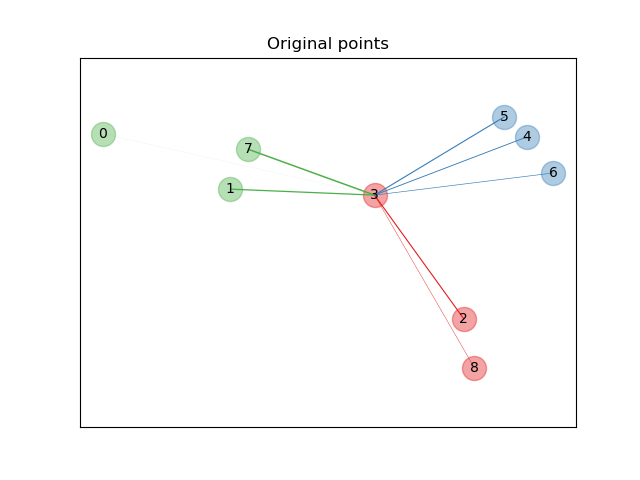

</a>

    
- nello spazio originario, l'es. `3` ha molti vicini di classi differenti $\to$ la classe giusta non è molto probabile;
    
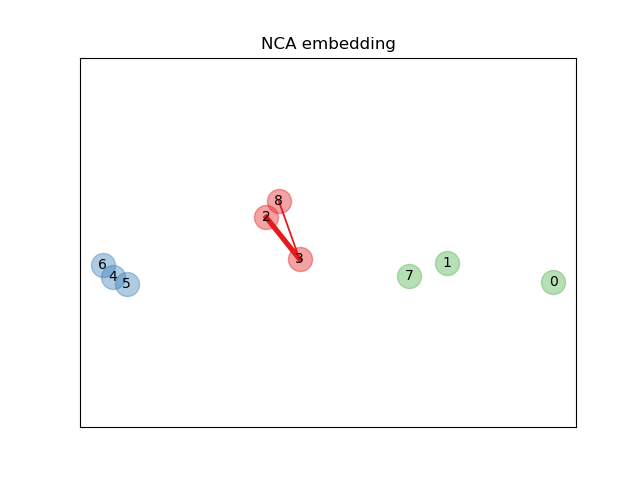 


- nello spazio appreso da NCA, gli unici vicini con peso non trascurabile appartengono alla stessa classe di `3`, migliorandone la classificazione. 




In [12]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

X, y = load_wine(return_X_y=True)

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X, y)
print("knn: %.2f"%(cross_val_score(knn, X, y).mean()*100))

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X, y)
print("nca: %.2f"%(cross_val_score(nca_pipe, X, y).mean()*100))
# cv = 5 (default)

knn: 70.29
nca: 73.70


#### Altro esempio

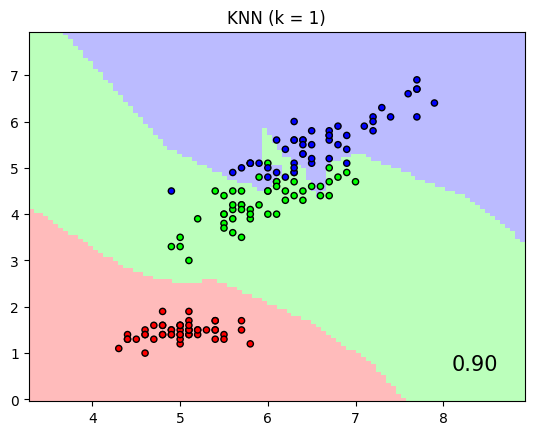

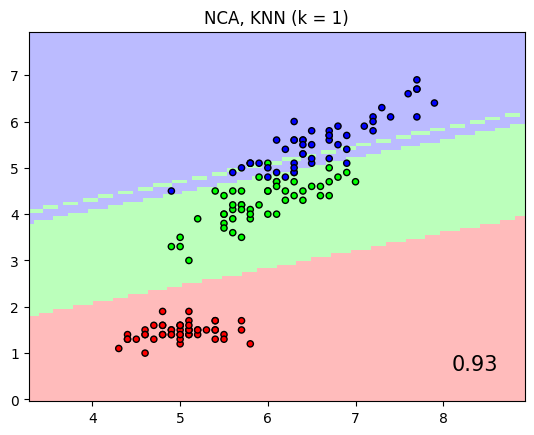

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

# si considerano solo 2 feature
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.7, random_state=42)

h = 0.05  # passo per la griglia mesh

# color map
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

names = ["KNN", "NCA, KNN"]

classifiers = [
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("nca", NeighborhoodComponentsAnalysis()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        alpha=0.8,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot punti di training e test
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    plt.title("{} (k = {})".format(name, n_neighbors))
    plt.text(
        0.9,
        0.1,
        "{:.2f}".format(score),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.show()

### Esempio: riduzione della dimensionalità con NCA

dalla [doc](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html) di sklearn

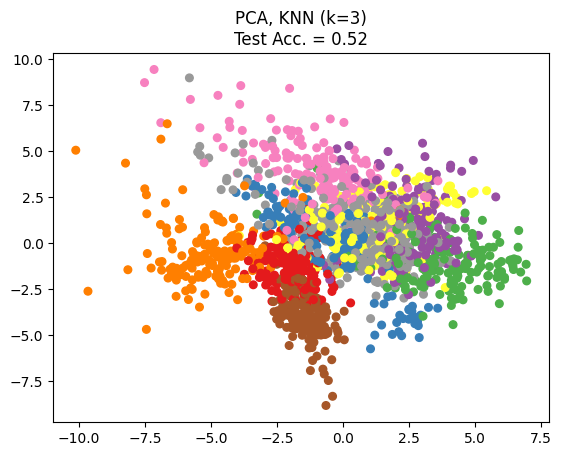

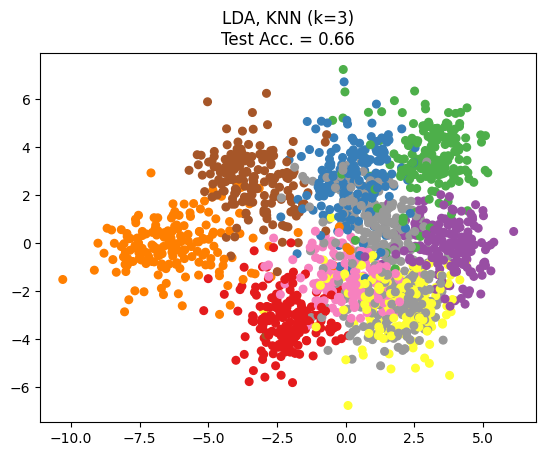

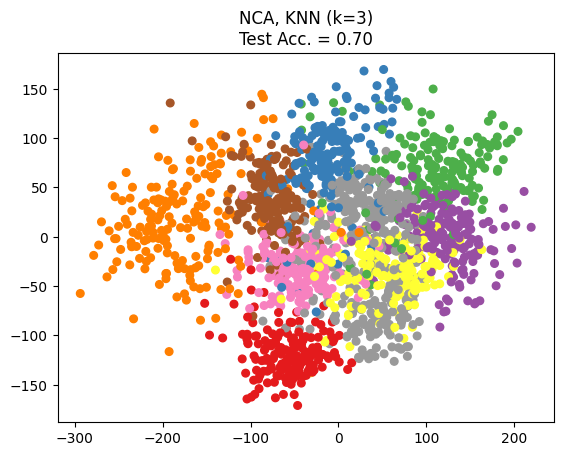

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 3
random_state = 0

# caricamento dataset
X, y = datasets.load_digits(return_X_y=True)

# partizionamento train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# riduzione a 2 dimensioni tramite PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# riduzione a 2 dimensioni tramite LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# riduzione a 2 dimensioni tramite NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Uso del nearest neighbor classifier per evaluare i metodi
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# lista dei metodi confrontati
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # addestramento modello
    model.fit(X_train, y_train)

    # addestramento nearest neighbor classifier sul training set embedded
    knn.fit(model.transform(X_train), y_train)

    # calcolo dell'accuracy sul test set embedded
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embedding del dataset in 2 dim. usando il modello
    X_embedded = model.transform(X)

    # Plot dei punti proiettati point e indicazione dello score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest Acc. = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()

_Caso analogo_: con un dataset artificiale con `3` classi

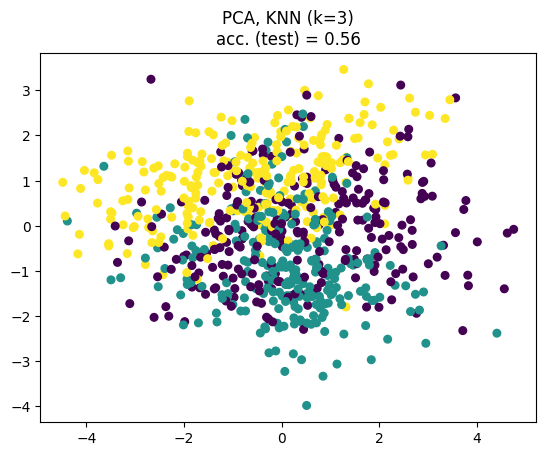

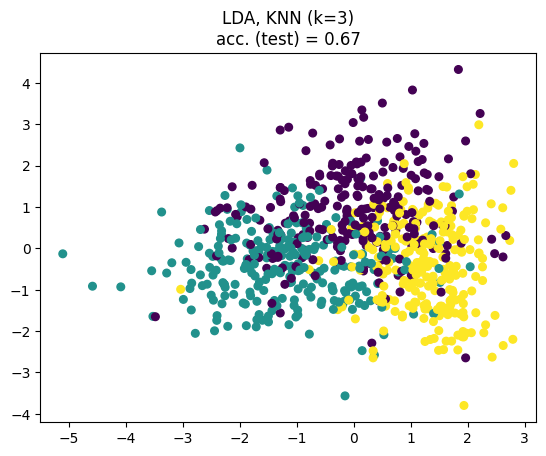

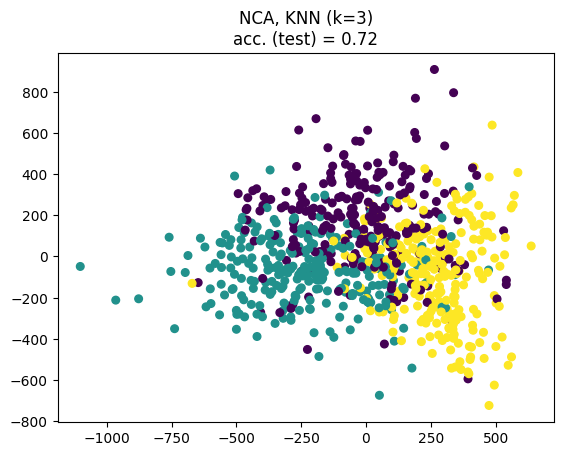

In [15]:
n_neighbors = 3
random_state = 0

from sklearn.datasets import make_classification

# creazione dataset
X, y = make_classification(n_samples=777, n_features=10, n_informative=7, 
                           n_classes=3, random_state=random_state)

# partizionamento train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# riduzione a 2 dimensioni con PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# riduzione a 2 dimensioni con LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# riduzione a 2 dimensioni con NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# KNN per la valutazione dei metodi di riduzione
knn = KNeighborsClassifier(n_neighbors=n_neighbors,)

# lista dei metodi confrontati
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # addestramento del metodo
    model.fit(X_train, y_train)

    # addestraento KNN sul training set dopo embedding
    knn.fit(model.transform(X_train), y_train)

    # calcolo accuratezza sul test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # trasformazione dataset in 2 dimensioni
    X_embedded = model.transform(X)

    # mostra punti e valutazione
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30)
    plt.title(
        "{}, KNN (k={})\nacc. (test) = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()

# Kernel Density Estimation

Metodo non-parametrico più complesso rispetto a quello basato su istogrammi, che può essere usato per apprendere un modello generativo per i dati.  

Dato il modello si possono estrarre campioni di nuovi esempi che riflettono la distribuzione implicita dei dati. 

## Stima di Densità: 

![§2.8](https://scikit-learn.org/stable/_images/sphx_glr_plot_kde_1d_001.png)

si veda la [doc](https://scikit-learn.org/stable/modules/density.html)

La KDE in scikit-learn è implementata con `KernelDensity`, che utilizza _Ball Tree_ o _KD Tree_ per rendere efficienti le query. 

Un kernel è una funzione positiva controllata dal parametro di _smoothing_ $h$ o _bandwidth_  

Stima di densità basata sul kernel per un certo punto $y$ all'interno di un gruppo di vicini: $$\rho(y)= \sum_1^K K(y-x_i | h)$$


Kernel più comuni:

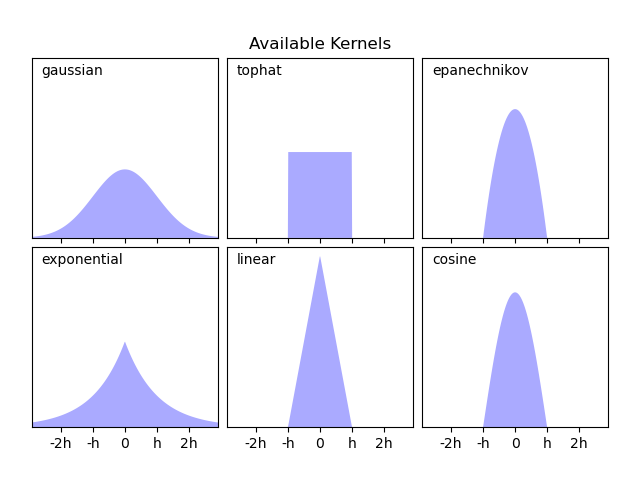

#### Esempio

- si utilizza un dataset 1D per semplicità
    + KDE ammette qualsiasi numero di dimensioni, ma dimensionalità elevate possono far degradare le prestazioni
- si estraggono $N$ punti casuali da una distribuzione bimodale, quindi vengono mostrate le stime della densità per tre scelte di kernel

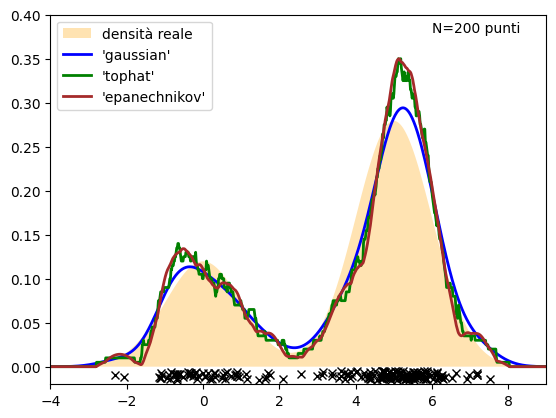

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

# creazione dati bimodali
N = 200
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)), 
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="orange", alpha=0.3, label="densità reale")
colors = ["blue", "green", "brown"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="'{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} punti".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "xk")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

#### Esempio KDE sul dataset delle cifre scritte a mano

Dalla [doc](https://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html#sphx-glr-auto-examples-neighbors-plot-digits-kde-sampling-py)  di `scikit-learn`

- cerca una $h$ ottimale
- dopo aver stimato la densità si _generano_ nuove cifre

migliore bandwidth: 3.79269019073225


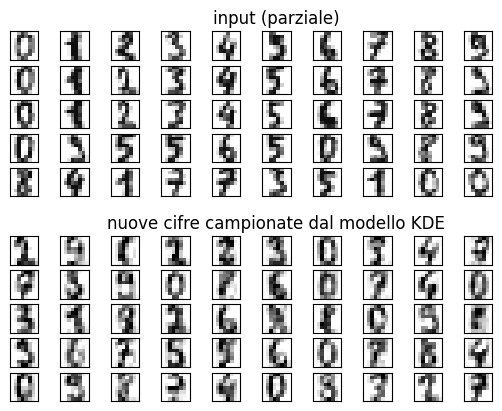

In [17]:
# Esempio modificato

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# caricamento dataset
digits = load_digits()

# riduzione della dim. originaria (da 64 a 16)
pca = PCA(n_components=16, whiten=False)
data = pca.fit_transform(digits.data)

# grid search CV per ottimizzare la bandwidth
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("migliore bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# usa il miglior modello di KDE
kde = grid.best_estimator_

# genera un campione di nuove istanze 
new_data = kde.sample(50, random_state=0)
new_data = pca.inverse_transform(new_data)

# converte in una griglia 5x10
new_data = new_data.reshape((5, 10, -1))
real_data = digits.data[:50].reshape((5, 10, -1))

# mostra cifre reali e cifre campionate
fig, ax = plt.subplots(11, 10, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(10):
    ax[5, j].set_visible(False)
    for i in range(5):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)), 
                             cmap=plt.cm.binary, interpolation="nearest")
        im.set_clim(0, 17)
        im = ax[i + 6, j].imshow(new_data[i, j].reshape((8, 8)), 
                                 cmap=plt.cm.binary, interpolation="nearest")
        im.set_clim(0, 17)

ax[0, 5].set_title('input (parziale)')
ax[6, 5].set_title('nuove cifre campionate dal modello KDE')

plt.show()

### Esercizi

Uso dei diversi modelli disponibili in `sklearn.neighbors`:
- per la classificazione: e.g. `RadiusNeighborsClassifier` con raggio di default
    + confronto sul dataset Iris (con tutti gli attributi) con `KNeighborsClassifier` usando l'accuratezza (default) come metrica
        * ai fini della ripetibilità usare lo stesso valore (ad es.`42`) per il generatore casuale
    + ulteriore estensione: ricerca con CV del miglior raggio (e k)
- per la regressione: e.g. `KNeighborsRegressor`
- stima della densità mediante kernel: `KernelDensity` applicato a un dataset noto

# SVM 
## e Altre Kernel Machine


dalla [doc](https://scikit-learn.org/stable/modules/svm.html#svm) di scikit-learn

Sezione: `sklearn.svm`
+ Classificazione
+ Regressione
+ Outlier / novelty detection
+ Riduzione dimensionalità

**Vantaggi** 

+ efficacia (tempo) su spazi ad alta dimensionalità
    + anche quando $d > N$
+ efficacia (spazio): modello determinato da poche istanze di training, i _support vector_
+ versatilità: basata sui diversi kernel utilizzabili 
    - oltre a quelli predefiniti è possibile specificare nuovi kernel ad hoc

**Svantaggi**

+ se $d \gg N$, vanno usati kernel adatti + regolarizzazione per evitare il sovradattamento
+ non forniscono stime probabilistiche direttamente 
    - ma possono essere ottenute via _5-fold CV_ 

In `sklearn` campioni con vettori sia *densi* (`numpy.ndarray` e convertibili tramite `numpy.asarray`) sia *sparsi* (`scipy.sparse`)
- per predizioni con dati sparsi, una SVM dev'essere adeestrata su tale tipo di dati
    - prestazioni ottimali con `numpy.ndarray` (densi) o `scipy.sparse.csr_matrix` (sparsi) con `dtype=float64`

## Classificazione

**classi**:

+ [`svm.LinearSVC([penalty, loss, dual, tol, C, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) <br>_Linear Support Vector_ Classification
+ [`svm.NuSVC(*[, nu, kernel, degree, gamma, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC) <br>_Nu-Support Vector_ Classification
+ [`svm.SVC(*[, C, kernel, degree, gamma, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) <br> _C-Support Vector_ Classification

`SVC` e `NuSVC` simili, ma con formulazione e parametri leggermente diversi 

`LinearSVC` altra implementazione (più veloce) per il caso di kernel lineare
- non accetta il parametro `kernel`, in quanto predefinito
- manca anche di altri attributi come `support_`

Come altri classificatori, accettano in input 2 array: 
- `X` di _shape_ `(n_samples, n_features)` istanze
- `y` di _shape_ `(n_samples)`, etichette delle classi, stringhe o interi

La _funzione di decisione_ dipende dai **vettori di supporto** 
- loro proprietà disponibili attraverso gli attributi `support_vectors_`, `support_` e `n_support_`

### Esempio SVC

cfr [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py)

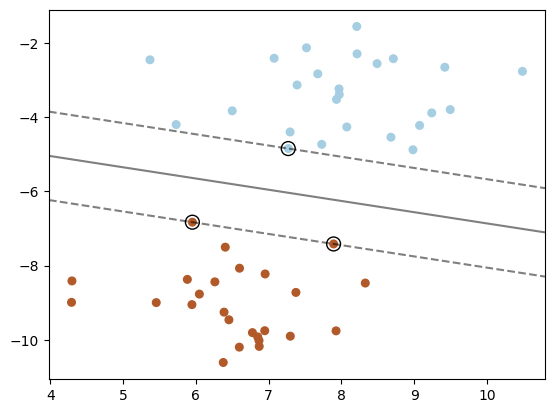

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# crea 50 istanze separabili, per default: n_features=2
X, y = make_blobs(n_samples=50, centers=2, random_state=6) 
# addestra il modello, senza regolarizzazione
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
# disegna funzione di decisione
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# griglia per la valutazione
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
# iperpiano e margini
ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
# vettori di supporto
ax.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],
           s=100,linewidth=1, facecolors="none", edgecolors="k")
plt.show()

### Esempio: caso non lineare

cfr. [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py)

dataset XOR

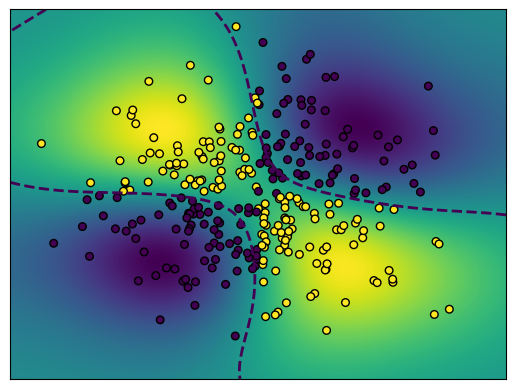

In [19]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(42)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
# addestramento
clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)
# plot della funz. di decisione per i punti nella griglia
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.imshow(Z,
           interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), 
           aspect="auto", 
           origin="lower")
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

### Esercizi

- stessa SVM con dataset diversi aggiungendo valutazione con CV
- idem + regolarizzazione
- idem ma con SVM diverse
- idem ma con kernel diversi

### Dataset Non Bilanciati

Parametri `class_weight` e `sample_weight` per problemi dove si deve dare _maggiore importanza_ a certe classi o istanze 

`SVC` 
- `class_weight` nel metodo `fit`: dizionario di forma `{class_label : value}`, dove `value` è un numero reale positivo che imposta `C` per la classe `class_label` pari a `C * value` 

`SVC`, `NuSVC`, `LinearSVC` e le altre classi
- `sample_weight` nel metodo `fit`: come il precedente imposta `C` ma per l'`i`-esima istanza a `C * sample_weight[i]`

#### Esempio

cfr [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html)

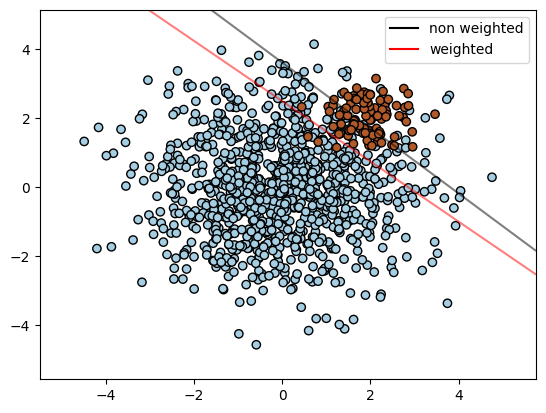

In [20]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 10})
wclf.fit(X, y)

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

# plot decision boundary and margins for weighted classes
wdisp = DecisionBoundaryDisplay.from_estimator(
    wclf,
    X,
    plot_method="contour",
    colors="r",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

plt.legend(
    [
        mlines.Line2D([], [], color="k", label="non weighted"),
        mlines.Line2D([], [], color="r", label="weighted"),
    ],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()

**Variazione**

- si provi anche `clf = SGDClassifier(n_iter=100, alpha=0.01)`

### Caso Multiclasse

`SVC` e `NuSVC` implementano la strategia *una-contro-una* 
- in totale: `n_classes * (n_classes - 1) / 2` classificatori 
    - ognuno addestrato con dati di 2 classi
- per coerenza con gli altri classificatori, l'opzione `decision_function_shape` consente di trasformare monotonicamente i risultati in una decisione *una-contro-resto* di <i>shape</i> `(n_samples, n_classes)`

`LinearSVC` implementa direttamente la strategia *una-contro-resto*, addestrando `n_classes` modelli





### Esempio con IRIS

cfr. [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html)

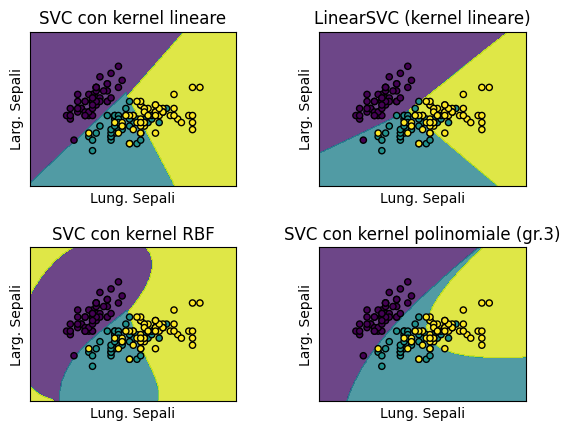

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# importa il dataset
iris = datasets.load_iris()
# considera le prime due feature
X = iris.data[:, :2]
y = iris.target

# crea istanza di SVM e l'addestra 
# dati non riscalati per mostrare i vettori di supporto
C = 1.0  # parametro di regolarizzazione 
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# titoli 
titles = (
    "SVC con kernel lineare",
    "LinearSVC (kernel lineare)",
    "SVC con kernel RBF",
    "SVC con kernel polinomiale (gr.3)",
)

# griglia 2x2 
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,  alpha=0.8)
    ax.scatter(X0, X1, c=y, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("Lung. Sepali")
    ax.set_ylabel("Larg. Sepali")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Regressione

+ [`svm.LinearSVR(*[, epsilon, tol, C, loss, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR) <br>Linear Support Vector Regression
+ [`svm.SVR(*[, kernel, degree, gamma, coef0, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) <br>Epsilon-Support Vector Regression
+ [`svm.NuSVR(*[, nu, C, kernel, degree, gamma, ...])`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR) <br>Nu Support Vector Regression


**Support Vector Regression**

Anche i modelli di regressione dipendono solo dai vettori di supporto: 
- si possono ignorare le istanze con predizione _vicina_ a quella corretta

Implementazioni: 
- `LinearSVR` più veloce ma solo con kernel lineare
- `NuSVR` implementa una formulazione differente rispetto a `SVR` e `LinearSVR`

#### Esempio: Uso di Kernel Lineari e Non 

cfr [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)

Regressione _monodimensionale_ con kernel lineare, polinomiale e RBF 

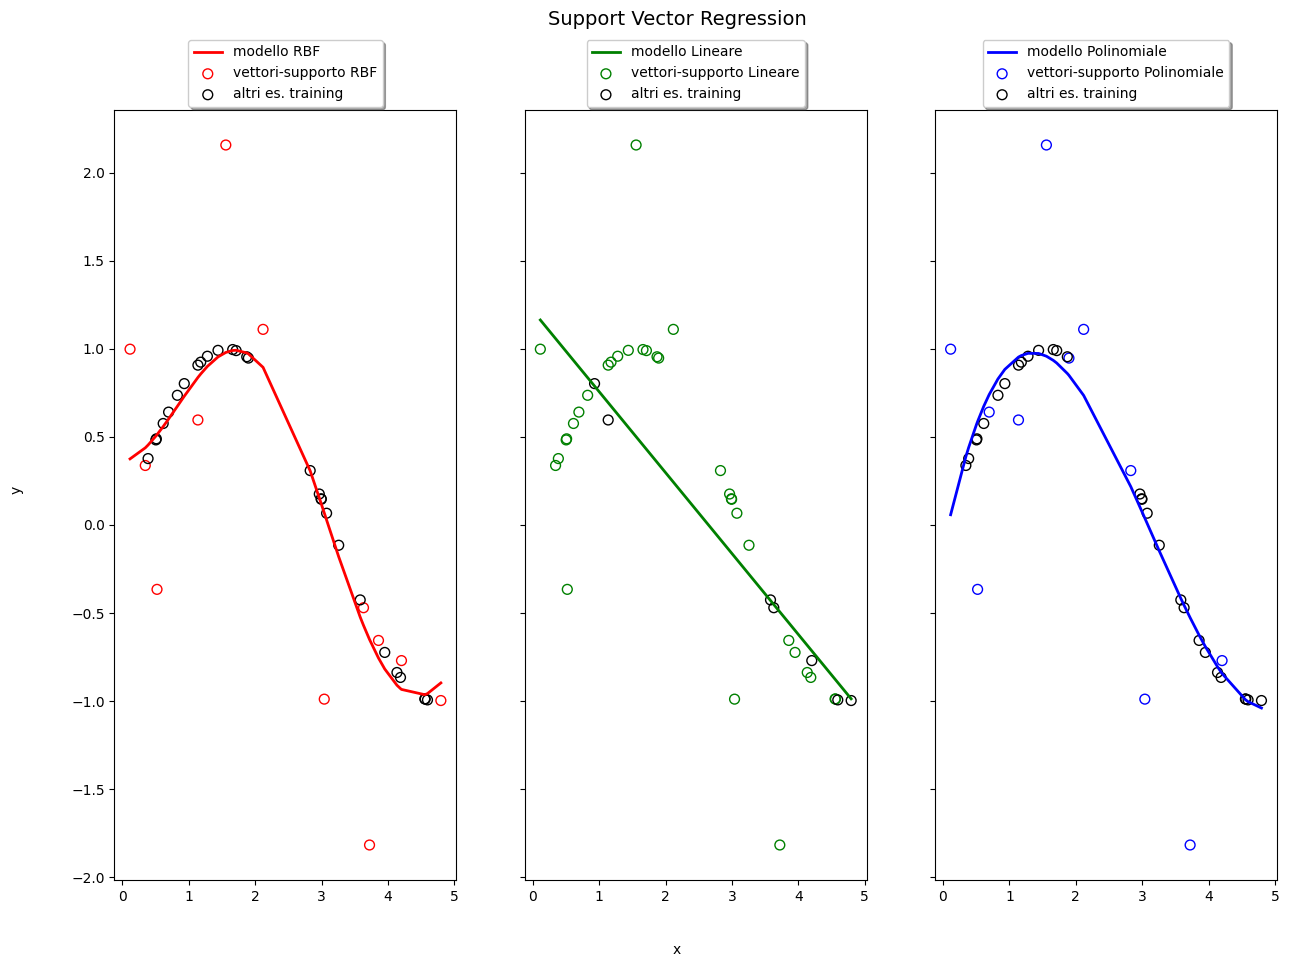

In [22]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Generazione dati
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# aggiunta rumore ai target
y[::5] += 3 * (0.5 - np.random.rand(8))

# apprendimento modello di regressione
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", 
               degree=3, epsilon=0.1, coef0=1)

# ispazione risultati
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Lineare", "Polinomiale"]
model_color = ["r", "g", "b"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="modello {}".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="vettori-supporto {}".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="altri es. training",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "x", ha="center", va="center")
fig.text(0.06, 0.5, "y", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## Kernel Ridge Regression

La __Kernel Ridge Regression__ (KRR) combina _Ridge regression_ e _classificazione_ (minimi quadrati lineari con regolarizzazione L2) con il _kernel trick_ 
- apprende una funzione lineare nello spazio indotto dal kernel e dai dati
    - per i kernel non lineari, ciò corrisponde a una funzione non lineare nello spazio originale
- forma del modello appreso identica a quella della SVR<br> ma impiegano _loss_ diverse, entrambe combinate con la regolarizzazione L2: 
    - KRR: loss dell'errore quadratico
    - SVR: loss $\epsilon$-insensibile
- [`KernelRidge`](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge) risolve un problema in _forma chiusa_ ed è tipicamente più veloce di `SVR` per dataset di medie dimensioni
- il modello appreso _non_ è _sparso_ e quindi più lento in fase di predizione di quello appreso dalla SVR, che è sparso (per $\epsilon>0$)


### Esempio: KRR vs SVR

dalla [doc](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py)

Migliore KRR con parametri: {'alpha': 0.1, 'gamma': np.float64(0.1)} e score R2: 0.723
KRR: selezione della complessità della SVR, larghezza di banda e apprendimento del modello in 0.273 s

Migliore SVR con parametri: {'C': 1.0, 'gamma': np.float64(0.1)} e score R2: 0.737
SVR: selezione della complessità e della larghezza di banda e apprendimento del modello in 0.663 s
Support vector ratio: 0.340

Predizione con SVR per 100000 input in 0.138 s
Predizione con KRR per 100000 input in 0.236 s


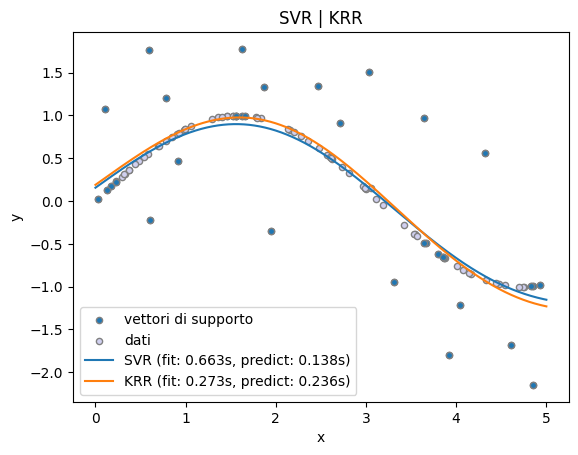

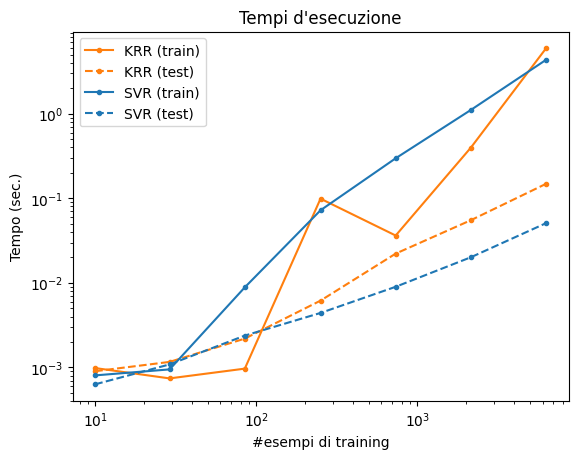

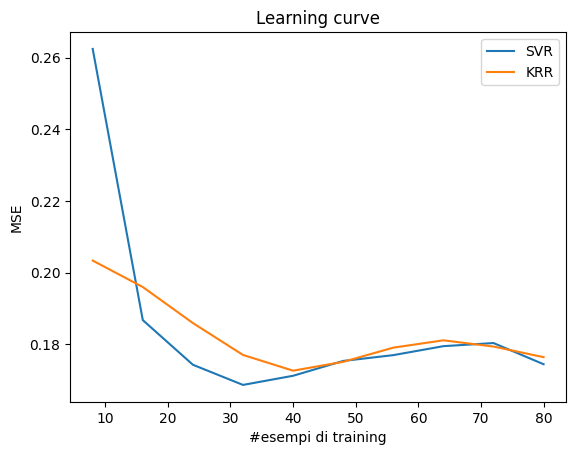

In [23]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay

# caricamento
rng = np.random.RandomState(42)

X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]


# costruzione modelli
train_size = 100

svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)


# confronto Tempi
t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print(f"Migliore KRR con parametri: {kr.best_params_} e score R2: {kr.best_score_:.3f}")
print("KRR: selezione della complessità della SVR, larghezza di banda e apprendimento del modello in %.3f s" % kr_fit)

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print(f"\nMigliore SVR con parametri: {svr.best_params_} e score R2: {svr.best_score_:.3f}")
print("SVR: selezione della complessità e della larghezza di banda e apprendimento del modello in %.3f s" % svr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("\nPredizione con SVR per %d input in %.3f s" % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("Predizione con KRR per %d input in %.3f s" % (X_plot.shape[0], kr_predict))


# Risultati
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c="C0", s=20, label="vettori di supporto", zorder=2, edgecolors="gray", linewidths=1)
plt.scatter(X[:100], y[:100], c="#D0D0F0", s=20, label="dati", zorder=1,edgecolors="gray", linewidths=1)
plt.plot(X_plot, y_svr, c="C0", label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c="C1", label="KRR (fit: %.3fs, predict: %.3fs)" % (kr_fit, kr_predict))
plt.xlabel("x")
plt.ylabel("y")
plt.title("SVR | KRR")
_ = plt.legend()

# Visualizzazione tempi

plt.figure()

sizes = np.logspace(1, 3.8, 7).astype(int)
for name, estimator in {
    "KRR": KernelRidge(kernel="rbf", alpha=0.01, gamma=10),
    "SVR": SVR(kernel="rbf", C=1e2, gamma=10),
}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, ".-", color="C0" if name == "SVR" else "C1", label="%s (train)" % name)
    plt.plot(sizes, test_time, ".--", color="C0" if name == "SVR" else "C1", label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("#esempi di training")
plt.ylabel("Tempo (sec.)")
plt.title("Tempi d'esecuzione")
_ = plt.legend(loc="best")


# curve di apprendimento
_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "score_type": "test",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curve")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.xlabel("#esempi di training")
plt.ylabel("MSE")

plt.show()

### Esercizi

- problemi regressione con dataset multivariato in `sklearn`
- problemi regressione con dataset esterno

## Outlier/Novelty Detection

[`OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) - SVM a classe singola usata per la _outlier_ o _novelty detection_

- algo non supervisionato: altre istanze diverse o simili a quelle del traioning set?
- dovendo aggiungere una nuova osservazione al dataset: 
    - è così diversa dalle altre da dubitare della sua regolarità?<br> ossia viene dalla stessa distribuzione? <br> _oppure_
    - è tanto simile alle altre da risultare indistinguibile dalle osservazioni originarie? 
 
- si deve determinare una _frontiera_ che approssimativamente vada a delimitare  il contorno della distribuzione delle osservazioni originarie, nello _spazio di embedding_
- se altre osservazioni ricadono nel sottospazio delimitato dalla frontiera saranno considerate appartenenti alla stessa popolazione _altrimenti_ si dirà che sono anomale con un grado di confidenza 

+ `svm.OneClassSVM(*[, kernel, degree, gamma, ...])` <br> _Unsupervised Outlier Detection_

    - richiede la scelta di un kernel e di un parametero scalare
        - spesso si usa l'RBF kernel sebbene non esista un modo per determinare il suo parametro `bandwidth`
        - `nu`, margine della SVM One-Class, corresponde alla probabilità di trovare una nuova istanza regolare al di fuori della frontiera

&nbsp;

- si veda anche la _versione online_ [`linear_model.SGDOneClassSVM`](https://scikit-learn.org/stable/modules/sgd.html#sgd-online-one-class-svm)

#### Esempio: Novelty Detection

cfr [doc](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html)

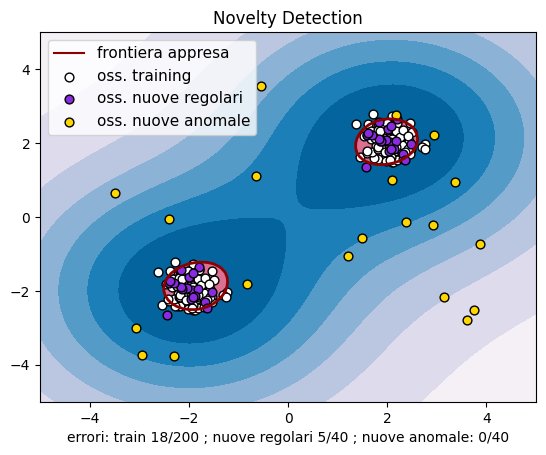

In [24]:
import numpy as np
from sklearn import svm
import matplotlib.font_manager
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Genera dati training
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Genera nuove oss. regolari
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate nuove oss. anomale
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# addestramento
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size


_, ax = plt.subplots()

# genera griglia per mostrare il boundary
xx, yy = np.meshgrid(np.linspace(-5, 5, 10), np.linspace(-5, 5, 10))
X = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    levels=[0, 10000],
    colors="palevioletred",
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contour",
    ax=ax,
    levels=[0],
    colors="darkred",
    linewidths=2,
)

s = 40
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = ax.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = ax.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.legend(
    [mlines.Line2D([], [], color="darkred"), b1, b2, c],
    [
        "frontiera appresa",
        "oss. training",
        "oss. nuove regolari",
        "oss. nuove anomale",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
ax.set(
    xlabel=(
        f"errori: train {n_error_train}/200 ; nuove regolari {n_error_test}/40 ;"
        f" nuove anomale: {n_error_outliers}/40"
    ),
    title="Novelty Detection",
    xlim=(-5, 5),
    ylim=(-5, 5),
)
plt.show()

## Esercizi

- usare le classi precedenti su dataset disponibili
- confrontare con il _Local Outlier Factor_

### Modulo `kernel_approximation`

Modulo contenente funzioni che approssimano __trasformazioni__ $\phi$ delle feature che corrispondono a determinati _kernel_, utilizzati nelle SVM: eseguono trasformazioni _non lineari_ dell'input, che possono servire come base per diversi algoritmi.

Vantaggio delle trasformazioni esplicite rispetto _kernel trick_ (mapping implicito): più adatte all'apprendimento _online_ riducendo significativamente il costo dell'apprendimento con dataset molto grandi. La combinazione di approssimazioni di $\phi$ con `SGDClassifier` può rendere possibile l'apprendimento di modelli non lineari su grandi dataset.

+ `kernel_approximation.AdditiveChi2Sampler(*)`: per kernel additivo _chi-quadro_
+ `kernel_approximation.Nystroem([kernel, ...])`: per kernel basato su un sottoinsieme del training set
+ `kernel_approximation.PolynomialCountSketch(*)`: per un kernel polinomiale tramite _Tensor Sketch_
+ `kernel_approximation.RBFSampler(*[, gamma, ...])`: per kernel RBF con feature di Fourier casuali
+ `kernel_approximation.SkewedChi2Sampler(*[, ...])`: per il kernel _skewed chi-squared_

### Esempio: approssimazione della trasformazione nel kernel RBF

dalla [doc](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)

Uso di `RBFSampler` e `Nystroem` per una SVM su dataset digits

Confronta:
- SVM lineare nello spazio originario
- SVM lineare con mapping approssimati 
- SVM kernelizzata

Tempi e accuratezze per campioni Monte Carlo di dim. diverse (per `RBFSampler`, che usa  feature di Fourier casuali) e training set di dim. diverse (per `Nystroem`) 



In [25]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, pipeline, svm
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem, RBFSampler

digits = datasets.load_digits(n_class=9)

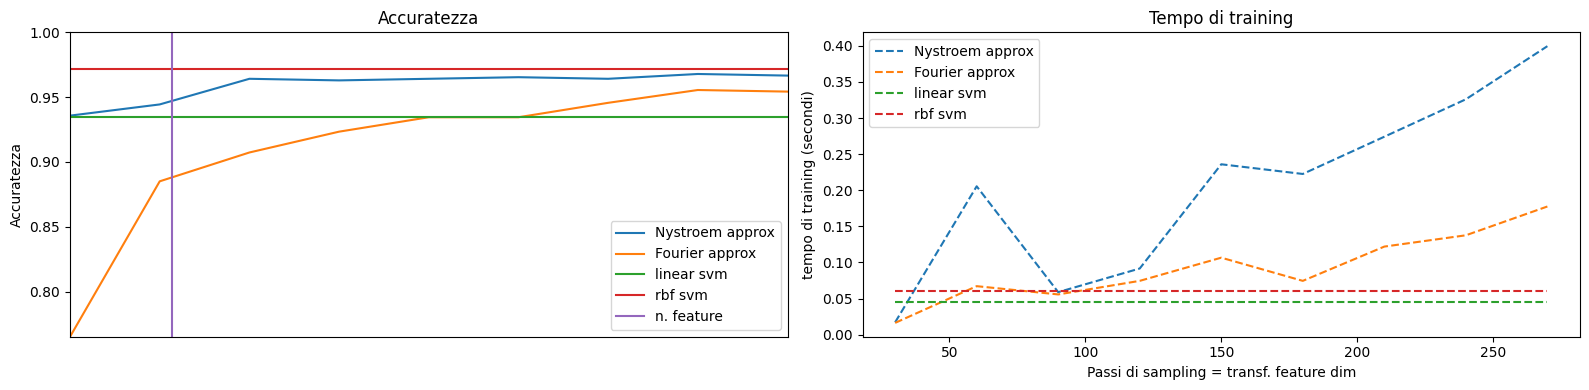

In [26]:
n_samples = len(digits.data)
data = digits.data / 16.0
data -= data.mean(axis=0)

# impara dalla prima metà
data_train, targets_train = (data[: n_samples // 2], digits.target[: n_samples // 2])

# test sulla seconda metà:
data_test, targets_test = (data[n_samples // 2 :], digits.target[n_samples // 2 :])
# data_test = scaler.transform(data_test)

# Crea classificatori
kernel_svm = svm.SVC(gamma=0.2)
linear_svm = svm.LinearSVC(dual="auto", random_state=42)

# crea la pipeline per l'approssimazione del kernel e per la svm lineare
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_fourier),
        ("svm", svm.LinearSVC(dual="auto", random_state=42)),
    ]
)

nystroem_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_nystroem),
        ("svm", svm.LinearSVC(dual="auto", random_state=42)),
    ]
)

# fit + predict con i vari classificatori:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# mostra i risultati:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# secondo y per i tempi
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx")
timescale.plot(sample_sizes, nystroem_times, "--", label="Nystroem approx")

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx")
timescale.plot(sample_sizes, fourier_times, "--", label="Fourier approx")

# linee orizzontali per kernel esatti rbf e lineare:
accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_score, linear_svm_score],
    label="linear svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_time, linear_svm_time],
    "--",
    label="linear svm",
)

accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_score, kernel_svm_score],
    label="rbf svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_time, kernel_svm_time],
    "--",
    label="rbf svm",
)

# linea verticale per la dim del dataset = 64
accuracy.plot([64, 64], [0.7, 1], label="n. feature")

# legenda ed etichette
accuracy.set_title("Accuratezza")
timescale.set_title("Tempo di training")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Passi di sampling = transf. feature dim")
accuracy.set_ylabel("Accuratezza")
timescale.set_ylabel("tempo di training (secondi)")
accuracy.legend(loc="best")
timescale.legend(loc="best")
plt.tight_layout()
plt.show()

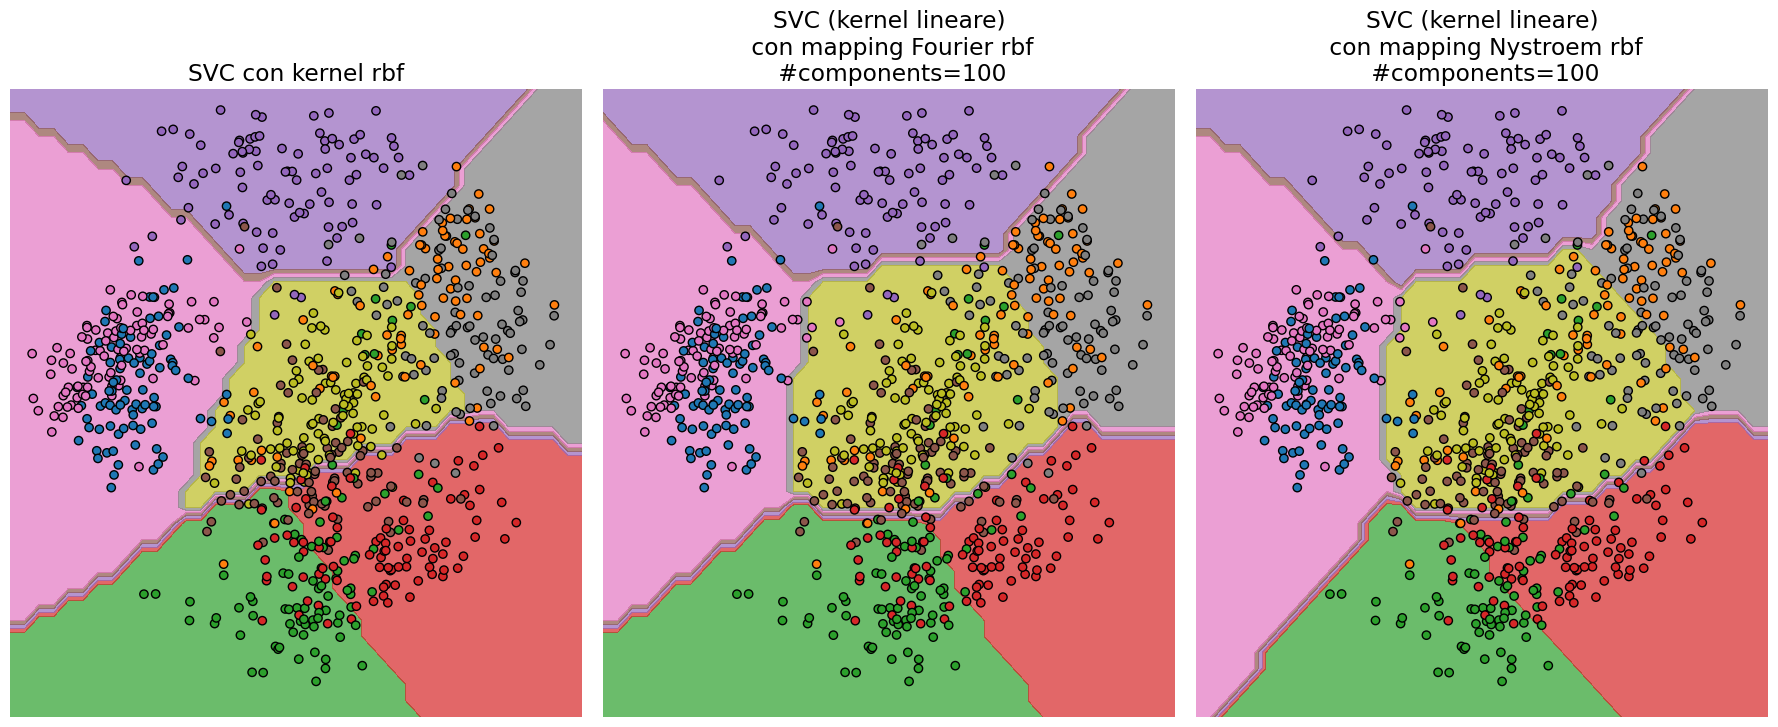

In [27]:
# visualizza la superficie di decisione
# proiettando sulle prime due componenti principali del dataset
pca = PCA(n_components=8, random_state=42).fit(data_train)

X = pca.transform(data_train)

# Genera la griglia delle prime due PC
multiples = np.arange(-2, 2, 0.1)
# passi sulla prima 
first = multiples[:, np.newaxis] * pca.components_[0, :]
# passi sulla seconda
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combinazione
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# titoli 
titles = [
    "SVC con kernel rbf",
    "SVC (kernel lineare)\n con mapping Fourier rbf\n #components=100",
    "SVC (kernel lineare)\n con mapping Nystroem rbf\n #components=100",
]

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({"font.size": 14})
# predizione e plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm, fourier_approx_svm)):
    # mostra il decision boundary
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    Z = Z.reshape(grid.shape[:-1])
    levels = np.arange(10)
    lv_eps = 0.01  
    plt.contourf(
        multiples,
        multiples,
        Z,
        levels=levels - lv_eps,
        cmap=plt.cm.tab10,
        vmin=0,
        vmax=10,
        alpha=0.7,
    )
    plt.axis("off")

    # es. di training
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=targets_train,
        cmap=plt.cm.tab10,
        edgecolors=(0, 0, 0),
        vmin=0,
        vmax=10,
    )

    plt.title(titles[i])
plt.tight_layout()
plt.show()

## Funzioni Kernel Predefinite

cfr. doc sezione [Pairwise metrics, Affinities and Kernels](https://scikit-learn.org/stable/modules/metrics.html#metrics)

In `metrics.pairwise`:
+ `laplacian_kernel(X[, Y, gamma])` kernel laplaciano fra `X` e `Y`
+ `linear_kernel(X[, Y, ...])`: kernel lineare 
+ `polynomial_kernel(X[, Y, ...])`: kernel polinomiale 
+ `rbf_kernel(X[, Y, gamma])`: kernel RBF (gaussiano)
+ `sigmoid_kernel(X[, Y, ...])`: kernel sigmoidale
+ `additive_chi2_kernel(X[, Y])`: kernel chi-quadro 
+ `chi2_kernel(X[, Y, gamma])`:  kernel chi-quadro esponenziale
+ `pairwise_kernels(X[, Y, ...])`: kernel fra gli array `X` e `Y` opzionali

## Modelli Non-parametrici: Processi Gaussiani

**Processo Gaussiano** (*Gaussian Process*, GP)
- metodo generale per l'apprendimento _supervisionato_ atto a risolvere problemi di
    - regressione 
    - classificazione probabilistica

Modulo [`sklearn.gaussian_process`](https://scikit-learn.org/stable/modules/gaussian_process.html)

+ `gaussian_process.GaussianProcessClassifier([...])` 
    - Gaussian process classification (GPC) basata su  approssimazione di Laplace 
+ `gaussian_process.GaussianProcessRegressor([...])` 
    - Gaussian process regression (GPR)

**Vantaggi**:

+ predizione per _interpolazione_ sulle istanze (anche attraverso kernel validi)
+ predizione _probabilistica_  per cui si possono calcolare  intervalli di confidenza empirica e decidere in base ad essi se riaddestrare (_online_, _adaptive fitting_) il modello per date regioni d'interesse
+ versatilità: si possono specificare diversi kernel
    - predefiniti o scritti ad hoc

**Svantaggi**:

+ mancanza di sparsità: usano l'intero campione e tutte le feature per fare predizioni
+ minore efficienza in caso di spazi ad alta dimensionalità
    - oltre qualche dozzina di feature

### Gaussian Process Regression 

`GaussianProcessRegressor` implementa GP per la regressione


A tal fine si devono specificare le info a priori del GP:
- per la _media_: assunto costante 
    - nullo  (se `normalize_y=False`) 
    - media sul training set (se `normalize_y=True`)
- per la _covarianza_: si passa un kernel
    - iperparametri del kernel ottimizzati nell'addestramento del `GaussianProcessRegressor`  massimizzando il log della _marginal-likelihood_ (LML) basata sull'ottimizzatore passato
        - più massimi locali $\to$ ripartenze ripetute specificando `n_restarts_optimizer` 
        - primo run con i valori iniziali degli iperparametri del kernel; successivi con valori casuali nel range consentito
        - iperparametri fissi passando `None` come ottimizzatore

_Livello di rumore_ nella feature target specificabile passandolo tramite il  parametro `alpha`, globalmente come scalare o per ciascuna istanza

- un livello di rumore moderato può essere utile a problemi di calcolo numerico nell'addestramento (implementato tramite regolarizzazione di Tikhonov, ossia con l'aggiunta nella diagonale della matrice di kernel)
    - alternativa: includendo una componente `WhiteKernel` nel kernel, che possa stimare il livello  globale di rumore dai dati 

**Implementazione**:

- consente la predizione anche senza addestramento  (si baserà sul GP come distr. a priori)
- metodo `sample_y(X)`: valuta campioni tratti dal GPR (a priori o a posteriori) per dati input
- metodo `log_marginal_likelihood(theta)`: usabile dall'esterno per altre modalità di selezione degli iperparametri, come MCMC

### Esempio: Problema di Regressione Monodimensionale

cfr. [doc](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)

Regressione in due modalità:

- senza rumore
- con rumore: _noise-level_ per ciascuna istanza

Stima ML dei parametri del kernel 

Nelle figure le proprietà d'interpolazione del modello GP e la sua natura probabilistica in forma di intervallo di confidenza puntuale al 95% 

- `alpha` parametro che controlla la forza della regolarizzazione (di Tikhonov) sulla matrice di covarianza assunta per le istanze di training

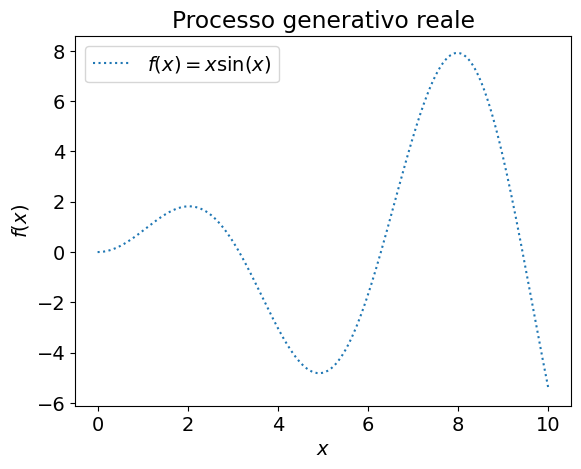

In [28]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Processo generativo reale")

In [29]:
# Processo generativo reale senza rumore aggiunto 
# training del GPR su pochi esempi.

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [30]:
# addestra un GP sui pochi esempi
# usando un kernel RBF e una costante come parametro per l'ampiezza

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e+4))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

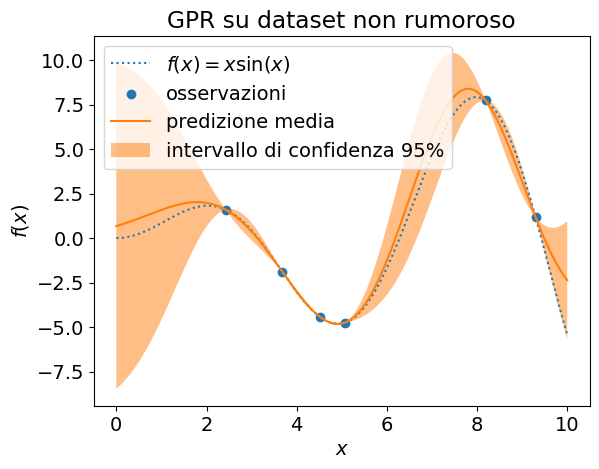

In [31]:
# Ottimizzati gli iperparametri del kernel,
# si del kernel per calcolare le predizioni medie sull'intero dataset 
# e plot dell'intervallo di confidenza al 95%

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="osservazioni")
plt.plot(X, mean_prediction, label="predizione media")
plt.fill_between(X.ravel(), 
                 mean_prediction - 1.96 * std_prediction,mean_prediction + 1.96 * std_prediction, 
                 alpha=0.5, 
                 label=r"intervallo di confidenza 95%")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("GPR su dataset non rumoroso")

In [32]:
# Aggiuta di rumore gaussiano alla f.target con dev.standard arbitaria
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

# crea un GPR simile al precedente 
# oltre al kernel si specifica il parametro alpha 
# da intepretarsi come la varianza del rumore gaussiano
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std ** 2, 
                                            n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

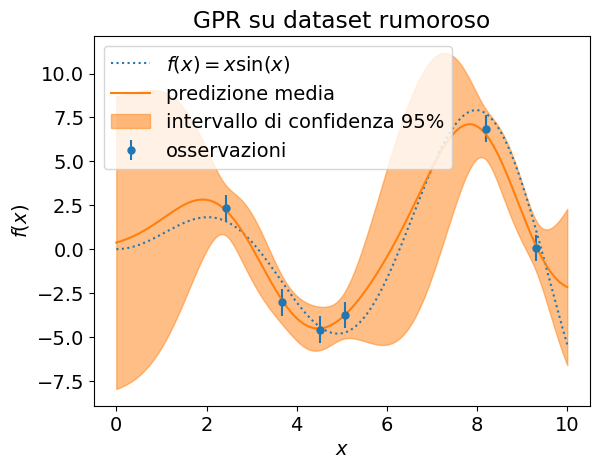

In [33]:
# plot simile al precedente ma per il nuovo modello

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(X_train, y_train_noisy,
             noise_std,
             linestyle="None",
             color="tab:blue",
             marker=".",
             markersize=10,
             label="osservazioni")
plt.plot(X, mean_prediction, label="predizione media")
plt.fill_between(X.ravel(),mean_prediction - 1.96 * std_prediction,mean_prediction + 1.96 * std_prediction,color="tab:orange",
                 alpha=0.5,label=r"intervallo di confidenza 95%")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("GPR su dataset rumoroso")

### Altri esempi con la GPR

- [Confronto con Ridge reg. kernelizzata](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py)
- [GPR su dataset Mauna Loa CO2](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)
- [GPR con stima livello di rumore mediante `WhiteKernel`](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py)


### Processi Gaussiani per la Classificazione

Implementati in `GaussianProcessClassifier`
- predizioni probabilistiche; 
- fissando una distribuzione a priori su una funzione latente detta _nuisance_ (cui viene applicata la funzione di squash) integrata durante la predizione; 
    - la funzione logistica di appiattimento utilizzata comporta problemi nel calcolo dell'integrale ma può essere approssimata nel caso binario
- __distr. a  posteriori__ della funzione latente non è Gaussiana non essendolo la likelihood (classi discrete) 
    - si usa una likelihood che corrisponde alla logistica, sfruttando poi l'approssimazione di Laplace (cfr. [RW2006](https://www.gaussianprocess.org/gpml/chapters/RW.pdf)).
- __distr. a priori__ a media nulla e covarianza specificata passando un oggetto `kernel`
    - iperparametri del kernel ottimizzati massimizzando il log della likelihood marginale con un ottimizzatore passato tramite `optimizer`
        - problema dei min. locali risolto con random restart specificando il loro numero con `n_restarts_optimizer`

GPC Supporta le modalità classificazione multi-classe _one-versus-rest_ e _one-versus-one_ 

- ma la “one_vs_one” non supporta anche la predizione delle probabilità stimate

### Altri Esempi con GPC

- [GPR e GPC su strutture dati discrete](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_on_structured_data.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-on-structured-data-py)
- [Predizioni probabilistiche con GPC](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc.html#sphx-glr-auto-examples-gaussian-process-plot-gpc-py)
- [Curve di Iso-probabilità per GPC](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_isoprobability.html#sphx-glr-auto-examples-gaussian-process-plot-gpc-isoprobability-py)


## Riduzione della Dimensionalità 

si può saltare (da prendere dopo le lezioni relative)

**Kernel Principal component analysis** (KPCA)

Riduzione della Dimensionalità Non-lineare attraverso l'uso di kernel


[`sklearn.decomposition.KernelPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA)

- usa l'implementazione LAPACK `scipy.linalg.eigh` della _SVD_ o `scipy.sparse.linalg.eigsh` della _SVD troncata_, a seconda della shape dell'input e del numero di componenti da estrarre
    - si può usare anche una _SVD troncata randomizzata_, cfr. `eigen_solver`

#### Esempio: Kernel PCA

cfr [doc](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html)

- Mostra la differenza fra Principal Components Analysis (`PCA`) e la sua versione kernelizzata (`KernelPCA`)
    - `KernelPCA` è capace di trovare una proiezione dei dati che li separa linearmente, al contrario di `PCA`
    - invertendo la proiezione, essa è esatta con `PCA`<br> mentre `KernelPCA` comporta un'approssimazione

**Creazione dataset**

In [34]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

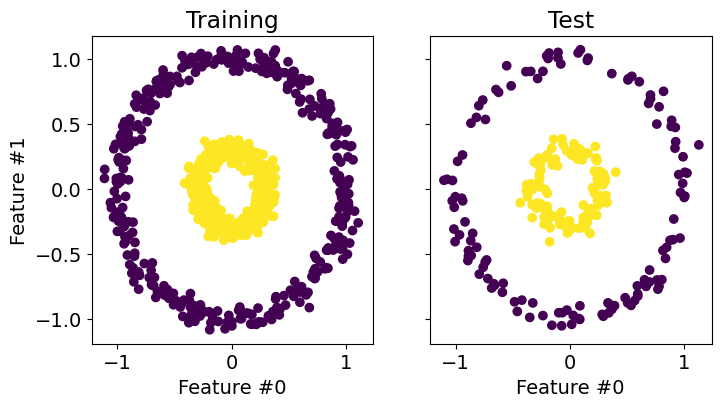

In [35]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Test")

**Addestramento**

In [36]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

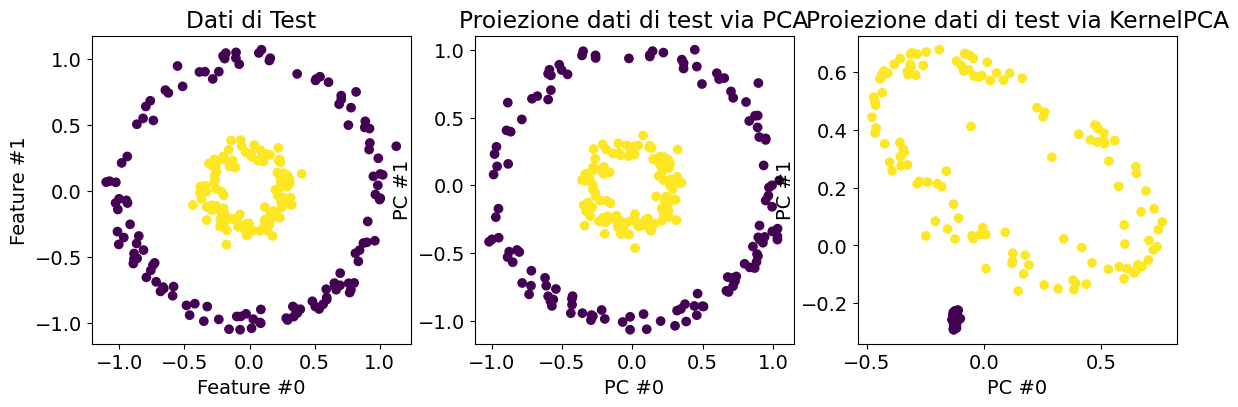

In [37]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Dati di test")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("PC #1")
pca_proj_ax.set_xlabel("PC #0")
pca_proj_ax.set_title("Proiezione dati di test - PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("PC #1")
kernel_pca_proj_ax.set_xlabel("PC #0")
_ = kernel_pca_proj_ax.set_title("Proiezione dati di test - KernelPCA")

**Inversione**

In [38]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

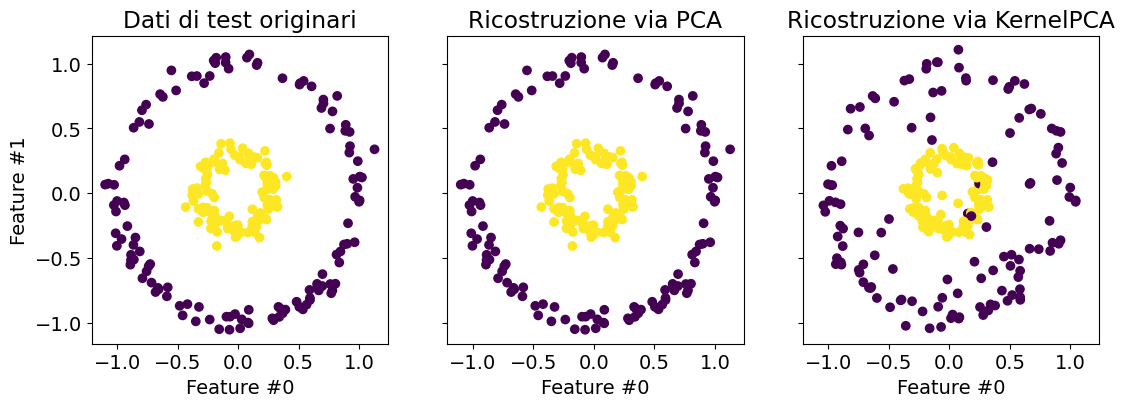

In [39]:
fig, (orig_data_ax, pca_back_proj_ax, kernel_pca_back_proj_ax) = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(13, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Dati di test originari")

pca_back_proj_ax.scatter(X_reconstructed_pca[:, 0], X_reconstructed_pca[:, 1], c=y_test)
pca_back_proj_ax.set_xlabel("Feature #0")
pca_back_proj_ax.set_title("Ricostruzione - PCA")

kernel_pca_back_proj_ax.scatter(
    X_reconstructed_kernel_pca[:, 0], X_reconstructed_kernel_pca[:, 1], c=y_test
)
kernel_pca_back_proj_ax.set_xlabel("Feature #0")
_ = kernel_pca_back_proj_ax.set_title("Ricostruzione - KernelPCA")

### Esercizi

- usare l'algoritmo su dataset disponibili in sklearn e altrove
- si confronti con l'esempio sul manuale